# Gradient Boosting Decision Trees, From Scratch

# Gradient Boosting Decision Trees, From Scratch

Gradient Boosting has been all the craze, in the predictive analytics world, for the last few years now. Gradient Boosting algorithms have won numerous Kaggle competitions, and are considered to be the standard in the industry now for regression problems that do not involve image/text data. 

But although its application is widespread, it is quite surprising, that there is less emphasis in knowing how it works. Many standard statistics/machine learning classes do not teach it. Most users treat it as a black box.

This is an attempt to understand, in a very simplistic way, how Gradient Boosting Regression works. Chapter 10 of [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/), which is free online, has an excellent treatment, and much of what I write here, is from that source. 

## What is Boosting?

Boosting is an example of what is called an "additive model". The setup here is that we have some data $x \in \mathbb{R}^m$, and some real valued labels, $y \in \mathbb{R}$. We want to find the true regression function $y = f(x)$. 
Additive models say, that we can try to find a good regression function by adding together a number of individual regression functions. Hence
$$\hat{y} = \sum f_k(x)$$

A number of models in machine learning can be expressed as additive models. For example, a neural network with a hidden layer, is an additive model where each neuron is an $f_k(x)$.

Boosting is a particular way to construct an additive model. The idea of boosting is to **iteratively learn a number of weak learners**, and add them up to construct a strong learner. The question is, how do we learn each weak learner?

There are a number of boosting algorithms, which propose to do this in different ways. The first boosting algorithm was Adaboost. Adaboost puts weights on each example. If previous weak learners have misclassified an example, Adaboost puts more weight on it, forcing the new learner to learn harder examples.

But Gradient Boosting has been one of the most successful implementations of boosting.


## What is Gradient Boosting?

Our goal is to learn $F(x)$ such that the loss function $L(y, F(x))$ is minimized. We want to learn this progressively, with weak learners. Let's say after m steps, we have learnt
$$F_m(x) = \sum_{k=1}^m f_k(x)$$

How to find the best $f_k(x)$ for the $(m+1)^{th}$ step. 

**Gradient descent!**

But this is gradient descent in the **function space**, and this is an important thing to understand. We want to learn a function which is in the direction of the gradient of the loss function with respect to the function space.
Therefore the function we want to learn is
$$g_{m+1} = \frac{\delta L(y,F(x))}{\delta F(x)}|_{F(x)=F_m(x)}$$

But this explanation is hard to understand.

### A more intuitive explanation
Lets say we have N data points, $x_1, x_2,...x_N$. We only get to evaluate this function at these points. So we can just equivalently think of this function as a point in the N-dim vector space. 
$$f_k(x) = [f_k(x_1), f_k(x_2).....f_k(x_n)]$$
Now, we want to add up all such N dim vectors, to get close to the N-dim vector of labels, which is 
$$[y_1,y_2,...y_N]$$

If we are standing at a given point in the N-dim space, how do we take a step to get "close" to the vector of labels? The word "close" mathematically means, a small value of the loss.
We take a step according to the gradient of the loss function in this space. Hence our new vector is another N-dim vector, which is the gradient of the loss function.

### Actual implementation
Lets take the square loss which is the easiest loss to work with. Here
$$L(y,F(x)) = \mathbb{E}(y - F(x))^2$$
Therefore, the gradient is simply:
$$\frac{\delta L(y,F(x))}{\delta F(x)}|_{F(x)=F_m(x)} = y - F_m(x)$$

But we are not considering all functions. For gradient boosted trees, we consider a subspace of the function space in the form of trees. Thus our goal now, is to find one function in that function space which is closest to this gradient.

That's it, that's the whole idea of gradient boosting trees. At each step, we find a good tree, that approximates the gradient, and keep adding these trees, to get as close to the true regression function as possible.

## Toy Example: From Scratch

Let's see how well this works. We will first make some data, and then we will make a very simple gradient boosted tree. Of course, we won't care about computational time, or overfitting etc. like in real implementations. We just want to see how it works.

### Make some data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import uniform, norm
import matplotlib.pyplot as plt 

In [7]:
#Make some data
np.random.seed(seed=42)
num_points = 100
x_val = uniform.rvs(loc=1, scale = 10, size=num_points)
x_val = np.sort(x_val)
y_val = -.5 *x_val**3 + 5 * x_val**2  + 3 * x_val + norm.rvs(size=num_points, scale=5)

# Also generate some test points with the same support
test_x = uniform.rvs(loc=1, scale = 10, size=1000)
test_x = np.sort(test_x)

We sample some x values uniformly, and then generate some y values as a 3rd degree polynomial with some Gaussian noise added. Let's see how this looks like.

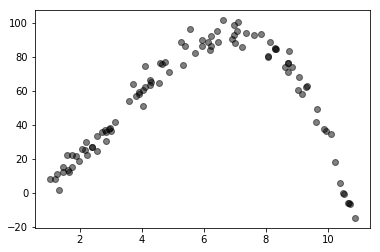

In [8]:
plt.plot(x_val, y_val, 'ko', alpha=0.5)

### A simple Decision Tree
We need to make a weak learner. We will use a very dumb one. This is a decision tree with one level. It tries to find the best split also in a very dumb way. Given n data points, it considers the (n-1) possible positions as splits, and find the one which gives the lowest squared error. the split() method implements this splitting. 

In [9]:
class DecisionStump(object):
    # We assume x is sorted
    def __init__(self,x, y):
        self.x = x
        self.y = y
        self.split_point = None
        self.left_pred = None
        self.right_pred = None

    def split(self):
        current_loss = np.inf 

        N = len(self.y)

        for i in range(2, len(self.x) -1):
            left_mean = np.mean(self.y[0:i])
            right_mean = np.mean(self.y[i:N])
            loss = sum([
              (self.y[j] - left_mean)**2 if j <i else (self.y[j] - right_mean)**2 
              for j in range(N)           
            ])

            if loss < current_loss:
                current_loss = loss
                self.split_point = self.x[i]
                self.left_mean = left_mean
                self.right_mean = right_mean
    
    def predict(self, new_x):
        if new_x < self.split_point:
            return self.left_mean 
        else:
            return self.right_mean


Let's see how this decision tree, often called a decision stump, works on our data. 


In [10]:
stump = DecisionStump(x=x_val, y=y_val)
stump.split()
test_y = np.array([stump.predict(x) for x in test_x])


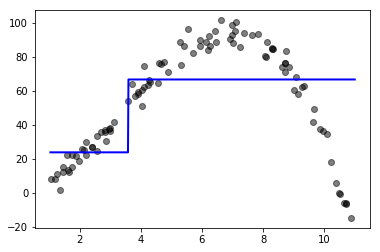

In [12]:
plt.plot(x_val, y_val, 'ko', alpha=0.5);
plt.plot(test_x,test_y, 'b-', linewidth=2);

This looks like a very bad regression function, as expected! But now, the magic of boosting will make it better!

### A Gradient Boosting Regresor
Now, we will use this tree to construct a gradient boosting regressor. The idea is simple. We make each tree, find the residuals, and fit the next tree to the residuals. We keep doing it, till we reach the number of trees specified by the user.

In [13]:
class GradientBoosting(object):
    def __init__(self, n_trees, x, y):
        self.n_trees = n_trees
        self.x = x
        self.y = y

        self.trees = []
    
    def fit(self):
        y_res = np.copy(self.y)

        for i in range(self.n_trees):
            this_tree = self._fit_one_round(self.x, y_res)
            self.trees.append(this_tree)
            this_tree_pred =  np.array([this_tree.predict(x) for x in self.x])
            y_res -= this_tree_pred
        

    def _fit_one_round(self, x, y):
        stump = DecisionStump(x=x, y=y)
        stump.split()
        return stump 
    
    def predict(self, new_x):
        new_y = sum([tree.predict(new_x) for tree in self.trees])
        return new_y    


Let's put this very simple Gradient Boosting Regressor to work on our original data. We will try 25 trees.

In [17]:
gbm = GradientBoosting(n_trees=25, x=x_val,y=y_val)
gbm.fit()

In [20]:
test_y_gbm = np.array([gbm.predict(x) for x in test_x])

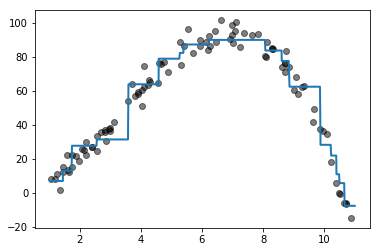

In [21]:
plt.plot(x_val, y_val, 'ko', alpha=0.5);
plt.plot(test_x, test_y_gbm, linewidth=2)

This is doing a pretty good job, given how simplistic it is!

Finally, lets see what happens when we keep increasing the number of trees. Of course, with a large number of trees you will overfit the training data.

In [23]:
def implement_gbm(num_trees):
    gbm = GradientBoosting(n_trees=num_trees, x=x_val,y=y_val)
    gbm.fit()
    test_y_gbm = np.array([gbm.predict(x) for x in test_x])
    plt.plot(x_val, y_val, 'ko', alpha=0.5);
    plt.plot(test_x, test_y_gbm, linewidth=2)

### Five Trees

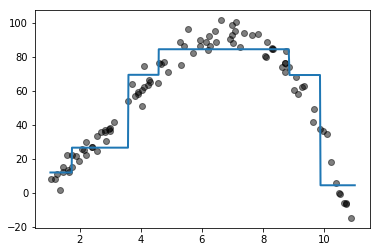

In [24]:
implement_gbm(num_trees=5)

### Twenty Trees

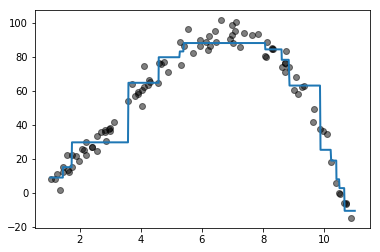

In [26]:
implement_gbm(num_trees=20)

### Fifty Trees

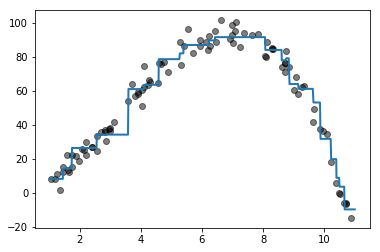

In [27]:
implement_gbm(num_trees=50)

### Hundred Trees

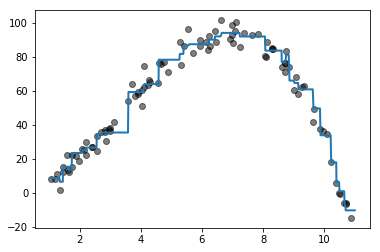

In [28]:
implement_gbm(num_trees=100)

## How are real implementations different
Scikit-learn has an implementation of GBM. Real implementations consider many different aspects, to prevent overfitting, reduce computational complexity
* They use real decision trees, which have more depth
* To prevent overfitting, a number of techniques such as regularization, or specifying minimum examples on a leaf node are used.
* You can also specify learning rate of gradient descent, use sub-sampling to learn each tree from a fraction of the training data, and so on.

One important thing to mention, the most popular boosting algorithm is xgboost. xgboost, while following similar general principles, has a slightly different way of finding the best trees. That is a topic for another day